## NEW KEYNESIAN MODEL
##### This file solves a New Keynesian model, reports unconditional and simulated moments, plots impulse responses, and does variance decomposition analysis.
$\textbf{by Ahmed Pirzada, University of Bristol}$

$\textbf{aj.pirzada@bristol.ac.uk}$

$\textbf{5th March 2025}$

---

$\textbf{MODEL Equations}$

We consider a three equation New Keynesian model you have seen in lectures. The three equations are the IS cuve, the Philips curve, and the Monetary Policy rule. These are also three shocks, each of which follows an AR(1) process (with no constant). These are productivity shock, cost shock, and a monetary policy shock.

1. IS curve: $x_{t} = \beta E_{t}x_{t+1} - \varphi(i_{t} - \pi_{t+1} - \bar{r}) - a_{t}$

2. NKPC curve: $\pi_{t} - \bar{\pi} = \beta E_{t}(\pi_{t+1} - \bar{\pi}) + \lambda x_{t} + u_{t}$

3. Taylor rule: $i_{t} = \bar{r} + \bar{\pi} + \chi_{\pi}(\pi_{t} - \bar{\pi}) + \chi_{x}x_{t} + m_{t}$

4. cost shock: $u_{t} = \rho_{u}u_{t-1} + \epsilon_{t}^{u}$

5. monetary shock: $m_{t} = \rho_{m}m_{t-1} + \epsilon_{t}^{m}$

6. productivity shock: $a_{t} = \rho_{a}a_{t-1} + \epsilon_{t}^{a}$

#### SET PATH FOR TOOLKIT IN GOOGLE DRIVE
Run this part of the code only if you are running this file in Google Colab. 
- **Start with** uploading this script and the toolkit file, *REmodelToolkit.py*, to the folder, Colab Notebooks, in your google drive.

In [ ]:
# This line imports the necessary functionality to interact with your Google Drive from within the Colab notebook.
from google.colab import drive

# This line makes sure that your Google Drive files are accessible within the notebook
drive.mount('/content/drive')

In [ ]:
# This command lists the files and directories inside the "Colab Notebooks" folder located in your Google Drive. You should see REmodelToolkit.py here. 
!ls "/content/drive/My Drive/Colab Notebooks"

In [ ]:
# These two lines ensure Python can find and import custom modules (e.g REmodelToolkit.py) located within your 'Colab Notebooks' folder in Google Drive, making them available to use in the notebook.
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

#### IMPORT PYTHON LIBRARIES

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from REmodelToolkit import gensys
from scipy.linalg import solve_discrete_lyapunov
from tabulate import tabulate
import pandas as pd


#### 1. SETUP THE MODEL

In [21]:
# ----------------------------------------
# Define model parameters
# ----------------------------------------
# IS parameters
beta   = 0.99  # Discount factor
varphi  = 1.0   # Intertemporal elasticity of substitution
# Phillips curve parameters
laambda  = 0.2   # Slope of the New Keynesian Phillips Curve (NKPC)
# Taylor rule parameters
chi_pi = 1.5   # Response of interest rate to inflation in Taylor rule
chi_x  = 0.5   # Response of interest rate to output gap in Taylor rule
# Steady state values
rbar = 0.01
pibar = 0.025
# Shock persistence and standard deviations
rho_u  = 0.8   # Persistence of cost-push shock
rho_m  = 0.5   # Persistence of monetary policy shock
rho_a  = 0.9   # Persistence of productivity (technology) shock
sigma_u = 0.02 # Standard deviation of cost-push shock
sigma_m = 0.01 # Standard deviation of monetary policy shock
sigma_a = 0.015 # Standard deviation of technology shock


# ----------------------------------------
# Model setup
# ----------------------------------------
# Ordering of variables: [x_{t}, π_{t}, i_{t}, u_{t}, m_{t}, a_{t}, x_{t+1}, π_{t+1}]
# 6 original variables + 2 auxiliary variables (expected x and pi)
n = 8    # Size of the vector
nax = 2  # Number of auxiliary variables
ny = n - nax    # Number of endogenous variables

# Initialize matrices for Gensys
g0    = np.zeros((n, n))  # Coefficients on y(t)
g1    = np.zeros((n, n))  # Coefficients on y(t-1)
c     = np.zeros((n, 1))  # Constant terms (set to zero in this case)
psi   = np.zeros((n, 3))  # Coefficients for exogenous shocks (3 shocks: u, m, a)
pi    = np.zeros((n, 2))  # Coefficients for expectational errors (eta_x, eta_pi)

#################################################################
# STEP 1: DEFINE AUXILIARY VARIABLES FOR EXPECTATIONS
#################################################################

# z^x_t = x_{t+1} (Auxiliary variable for expected output gap)
i = 0
g0[i, 0] =  1  # x_t
g1[i, 6] =  1  # z^{x}_{t-1} = x_{t}
pi[i, 0] =  1  # Expectation error for x

# z^pi_t = pi_{t+1} (Auxiliary variable for expected inflation)
i = 1
g0[i, 1] =  1  # pi_t
g1[i, 7] =  1  # z^{pi}_{t-1} = pi_{t}
pi[i, 1] =  1  # Expectation error for pi

#################################################################
# STEP 2: MODEL EQUATIONS
#################################################################

# --------- IS Curve (Aggregate Demand) ---------
# x_t = beta * z^x_t - varphi (i_t - z^pi_t - rbar) - a_t
i = 2
g0[i, 0] =  1        # x_t
g0[i, 2] =  varphi  # i_t (Interest rate)
g0[i, 5] =  1        # a_t (Technology shock)
g0[i, 6] = -beta     # z^x_t (Expected x_{t+1})
g0[i, 7] = -varphi  # z^pi_t (Expected pi_{t+1})
c[i] = rbar*varphi

# --------- New Keynesian Phillips Curve (NKPC) ---------
# pi_t - pibar = beta * (z^pi_t - pibar) + laambda * x_t + u_t
i = 3
g0[i, 1] =  1        # pi_t
g0[i, 0] = -laambda    # x_t
g0[i, 3] = -1        # u_t (Cost-push shock)
g0[i, 7] = -beta     # z^pi_t (Expected inflation)
c[i] = (1-beta)*pibar

# --------- Taylor Rule (Monetary Policy) ---------
# i_t = rbar + pibar chi_pi * (pi_t - pibar) + chi_x * x_t + m_t
i = 4
g0[i, 2] =  1        # i_t
g0[i, 1] = -chi_pi   # pi_t
g0[i, 0] = -chi_x    # x_t
g0[i, 4] = -1        # m_t (Monetary policy shock)
c[i] = rbar + (1 - chi_pi)*pibar

# --------- Shock Processes (Exogenous AR(1) Processes) ---------

# Cost-push shock: u_t = rho_u * u_{t-1} + eps_u
i = 5
g0[i, 3] =  1
g1[i, 3] =  rho_u
psi[i, 0] =  1  # epsilon_u

# Monetary policy shock: m_t = rho_m * m_{t-1} + eps_m
i = 6
g0[i, 4] =  1
g1[i, 4] =  rho_m
psi[i, 1] =  1  # epsilon_m

# Technology shock: a_t = rho_a * a_{t-1} + eps_a
i = 7
g0[i, 5] =  1
g1[i, 5] =  rho_a
psi[i, 2] =  1  # epsilon_a

#### 2. SOLVE THE MODEL USING CHRIS SIMS' GENSYS ALGORITHM

In [22]:
# -----------------------------------------------------------------------------
# Solve the New Keynesian Model using Chris Sims' Gensys Algorithm
# -----------------------------------------------------------------------------
# The function `gensys` solves a **linear rational expectations model** of the form:
#
#      G0 * y_t = G1 * y_{t-1} + C + Psi * epsilon_t + Pi * eta_t
#
# The solution takes the form:
#
#      y_t = G1_sol * y_{t-1} + C_vec + Impact * epsilon_t
#
# Where:
#  - `G1_sol` is the transition matrix mapping past states to current states.
#  - `C_vec` is the vector of constants.
#  - `Impact` determines how shocks influence the system.
#  - `gev` contains the **generalised eigenvalues**, which help assess stability.
#  - `eu` (existence and uniqueness flags) indicate whether a unique solution exists.
# -----------------------------------------------------------------------------

# Solve the model using Sims' Gensys algorithm.
G1_sol, C_vec, Impact, fmat_dummy, fwt, ywt, gev, eu, loose = gensys(g0, g1, c, psi, pi)

# -----------------------------------------------------------------------------
# Check for **Existence and Uniqueness** of the Solution
# -----------------------------------------------------------------------------
# The variable `eu` (existence & uniqueness) contains two elements:
#   - eu[0] = 1 if a solution **exists**.
#   - eu[1] = 1 if the solution is **unique**.
#   - If eu = [1, 1], then we have a unique stable solution.
#   - If eu = [1, 0], the solution **exists but is indeterminate** (multiple solutions).
#   - Otherwise, no stable solution exists.
# -----------------------------------------------------------------------------

print("Existence and uniqueness flags (eu):", eu)

# Set the printing format:
np.set_printoptions(precision=2, suppress=True)  # Show numbers up to 2 decimal places, suppress scientific notation

# Interpret the solution based on the `eu` values:
if np.array_equal(eu, [1, 1]):  # Unique stable solution case
    print("Unique stable solution found!")
    print("G1 (transition matrix):\n", G1_sol)
    print("C (constant term):\n", C_vec)
    print("Impact (shock matrix):\n", Impact)
    print("Generalised eigenvalues (gev):\n", gev)

elif np.array_equal(eu, [1, 0]):  # Indeterminate case
    print("Solution exists but is **not unique** (indeterminacy).")

else:  # No solution case
    print("Solution does not exist or an unexpected error occurred.")


Existence and uniqueness flags (eu): [1 1]
Unique stable solution found!
G1 (transition matrix):
 [[ 0.   -0.    0.   -1.95 -0.36 -0.53 -0.   -0.  ]
 [ 0.   -0.    0.    1.97 -0.14 -0.97  0.    0.  ]
 [ 0.   -0.    0.    1.98  0.11 -1.71  0.    0.  ]
 [ 0.   -0.   -0.    0.8   0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.5   0.    0.   -0.  ]
 [-0.    0.    0.    0.   -0.    0.9  -0.   -0.  ]
 [-0.    0.    0.   -1.56 -0.18 -0.47 -0.   -0.  ]
 [ 0.   -0.   -0.    1.58 -0.07 -0.87  0.    0.  ]]
C (constant term):
 [[-0.  ]
 [ 0.03]
 [ 0.04]
 [ 0.  ]
 [ 0.  ]
 [-0.  ]
 [-0.  ]
 [ 0.03]]
Impact (shock matrix):
 [[-2.44 -0.71 -0.58]
 [ 2.46 -0.28 -1.07]
 [ 2.48  0.22 -1.9 ]
 [ 1.    0.   -0.  ]
 [ 0.    1.    0.  ]
 [-0.   -0.    1.  ]
 [-1.95 -0.36 -0.53]
 [ 1.97 -0.14 -0.97]]
Generalised eigenvalues (gev):
 [[1.51 0.  ]
 [2.03 0.  ]
 [1.12 0.  ]
 [0.81 0.65]
 [1.09 0.55]
 [0.93 0.84]
 [0.5  0.76]
 [0.69 0.83]]


#### 3. WRITING THE SOLUTION FOR EACH VARIABLE SEPERATELY

In [23]:
# Define labels for your state/forward-looking variables (in the order you use them).
y_labels = [
    "x_{t}",      # 1
    "π_{t}",      # 2
    "i_{t}",      # 3
    "u_{t}",      # 4
    "m_{t}",      # 5
    "a_{t}",      # 6
]

# Define labels for your shocks (in the order you use them).
shock_labels = [
    "eps^{u}_{t}",
    "eps^{m}_{t}",
    "eps^{a}_{t}"
]

# Print each equation using the linear solution y_t = G1_sol * y_{t-1} + C_vec + Impact * eps_t
for i, var_name in enumerate(y_labels):
    # Start the equation string, e.g. "z^x_{t} = ..."
    eq_string = f"{var_name} = "

    # Add constant term C_vec
    if abs(C_vec[i]) > 1e-12:
        eq_string += f" {C_vec[i].item():.4g} + "

    # Add G1_sol terms
    terms_g1 = []
    for j, lagged_var_name in enumerate(y_labels):
        coeff = G1_sol[i, j]
        # Only include non-negligible coefficients
        if abs(coeff) > 1e-12:
            # Replace the "_{t}" with "_{t-1}" for the lag
            lagged_var_lag = lagged_var_name.replace("_{t}", "_{t-1}")
            terms_g1.append(f"{coeff:.4g}·{lagged_var_lag}")
    eq_string += " + ".join(terms_g1) if terms_g1 else "0"

    # Add shock impact terms
    for k, shock_name in enumerate(shock_labels):
        coeff_shock = Impact[i, k]
        if abs(coeff_shock) > 1e-12:
            eq_string += f" + {coeff_shock:.4g}·{shock_name}"

    print(eq_string)


x_{t} = -1.949·u_{t-1} + -0.3569·m_{t-1} + -0.5263·a_{t-1} + -2.437·eps^{u}_{t} + -0.7138·eps^{m}_{t} + -0.5848·eps^{a}_{t}
π_{t} =  0.025 + 1.972·u_{t-1} + -0.1413·m_{t-1} + -0.9658·a_{t-1} + 2.465·eps^{u}_{t} + -0.2827·eps^{m}_{t} + -1.073·eps^{a}_{t}
i_{t} =  0.035 + 1.983·u_{t-1} + 0.1096·m_{t-1} + -1.712·a_{t-1} + 2.479·eps^{u}_{t} + 0.2191·eps^{m}_{t} + -1.902·eps^{a}_{t}
u_{t} = 0.8·u_{t-1} + 1·eps^{u}_{t}
m_{t} = 0.5·m_{t-1} + 1·eps^{m}_{t}
a_{t} = 0.9·a_{t-1} + 1·eps^{a}_{t}


#### 4. UNCONDITIONAL MOMENTS

In [24]:
def compute_unconditional_moments(G1_sol, C_sol, impact, Sigma_z):
    """
    Computes the unconditional mean and covariance for the linear system:
    
        y(t) = G1_sol * y(t-1) + C_sol + impact * z(t),
    
    where z(t) ~ N(0, Sigma_z).

    Parameters
    ----------
    G1_sol : np.ndarray, shape (n, n)
        Transition matrix for y(t-1) => y(t).
    C_sol  : np.ndarray, shape (n,) or (n,1)
        Constant vector for the system (flattened if needed).
    impact : np.ndarray, shape (n, nz)
        Mapping from shocks z(t) to y(t).
    Sigma_z : np.ndarray, shape (nz, nz)
        Covariance matrix of the shock vector z(t).

    Returns
    -------
    mu_y : np.ndarray, shape (n,)
        Unconditional mean of y(t).
    Sigma_y : np.ndarray, shape (n, n)
        Unconditional covariance of y(t).
    """

    # Ensure C_sol is a 1D array
    C_sol = C_sol.flatten()

    # 1) Compute the unconditional mean: mu_y = (I - G1_sol)^{-1} * C_sol
    n = G1_sol.shape[0]
    I_n = np.eye(n)
    # We'll check if (I - G1_sol) is invertible
    M = I_n - G1_sol
    if np.linalg.matrix_rank(M) < n:
        raise ValueError("Matrix (I - G1_sol) is singular => can't compute unconditional mean.")
    
    mu_y = np.linalg.inv(M) @ C_sol

    # 2) Compute the unconditional covariance by solving the discrete Lyapunov equation:
    #    Sigma_y = G1_sol * Sigma_y * G1_sol' + impact * Sigma_z * impact'
    Q = impact @ Sigma_z @ impact.T
    # Solve for Sigma_y
    Sigma_y = solve_discrete_lyapunov(G1_sol, Q)

    return mu_y, Sigma_y


# Specify variance-covariance matrix for the shocks
Sigma_z = np.diag([sigma_u**2, sigma_m**2, sigma_a**2])

# Compute unconditional mean and covariance
mu_y, Sigma_y = compute_unconditional_moments(G1_sol[:ny,:ny], C_vec[:ny], Impact[:ny,:], Sigma_z)

In [25]:
def print_mean_cov(mu_y, Sigma_y, varnames=None):
    """
    Print the unconditional mean (mu_y) and covariance (Sigma_y) in a formatted table
    using 'tabulate'.
    
    Parameters
    ----------
    mu_y : np.ndarray, shape (n,)
        Unconditional mean of each variable.
    Sigma_y : np.ndarray, shape (n, n)
        Unconditional covariance matrix of the variables.
    varnames : list of str, optional
        List of variable names of length n. If not provided, uses Var0..Var(n-1).
    """
    n = len(mu_y)
    if varnames is None:
        varnames = [f"Var{i}" for i in range(n)]
    
    # 1) Print a one-column table for the unconditional mean
    #    e.g.  Var   Mean
    table_mean = [["Variable", "Mean"]]
    for i in range(n):
        table_mean.append([varnames[i], f"{mu_y[i]:.4f}"])
    
    print("=== Unconditional Mean ===")
    print(tabulate(table_mean, headers="firstrow", tablefmt="pretty"))
    print()
    
    # 2) Print a 2D table for the covariance matrix
    #    The top row is ["Var\\Var", var1, var2, ...]
    #    Each subsequent row is [var_i, Sigma_y[i,0], Sigma_y[i,1], ...]
    header = ["Var \\ Var"] + varnames
    table_cov = [header]
    for i in range(n):
        row = [varnames[i]]
        for j in range(n):
            row.append(f"{Sigma_y[i,j]:.4f}")
        table_cov.append(row)
    
    print("=== Unconditional Covariance Matrix ===")
    print(tabulate(table_cov, headers="firstrow", tablefmt="pretty"))

# Set the printing format:
np.set_printoptions(precision=4, suppress=True)  # optional for raw printing

# Define variable names for printing
varnames   = ["Output Gap", "Inflation", "Interest Rate","Cost Shock", "MP Shock", "Prod Shock"]

# Print with a nice table
print_mean_cov(mu_y, Sigma_y, varnames=varnames) 


=== Unconditional Mean ===
+---------------+---------+
|   Variable    |  Mean   |
+---------------+---------+
|  Output Gap   | -0.0000 |
|   Inflation   | 0.0250  |
| Interest Rate | 0.0350  |
|  Cost Shock   | 0.0000  |
|   MP Shock    | 0.0000  |
|  Prod Shock   | -0.0000 |
+---------------+---------+

=== Unconditional Covariance Matrix ===
+---------------+------------+-----------+---------------+------------+----------+------------+
|   Var \ Var   | Output Gap | Inflation | Interest Rate | Cost Shock | MP Shock | Prod Shock |
+---------------+------------+-----------+---------------+------------+----------+------------+
|  Output Gap   |   0.0071   |  -0.0059  |    -0.0054    |  -0.0027   | -0.0001  |  -0.0007   |
|   Inflation   |  -0.0059   |  0.0081   |    0.0092     |   0.0027   | -0.0000  |  -0.0013   |
| Interest Rate |  -0.0054   |  0.0092   |    0.0111     |   0.0028   |  0.0000  |  -0.0023   |
|  Cost Shock   |  -0.0027   |  0.0027   |    0.0028     |   0.0011   |  0.0

#### 5. IMPULSE RESPONSES

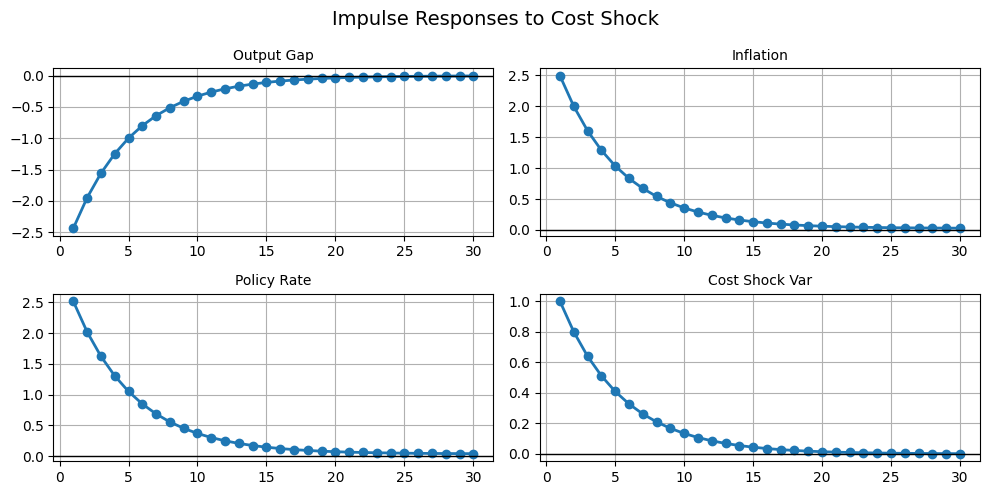

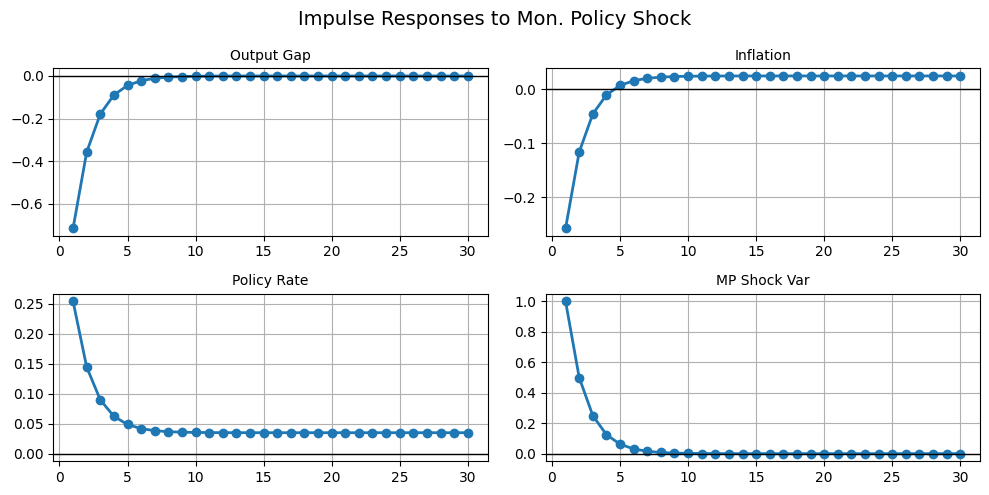

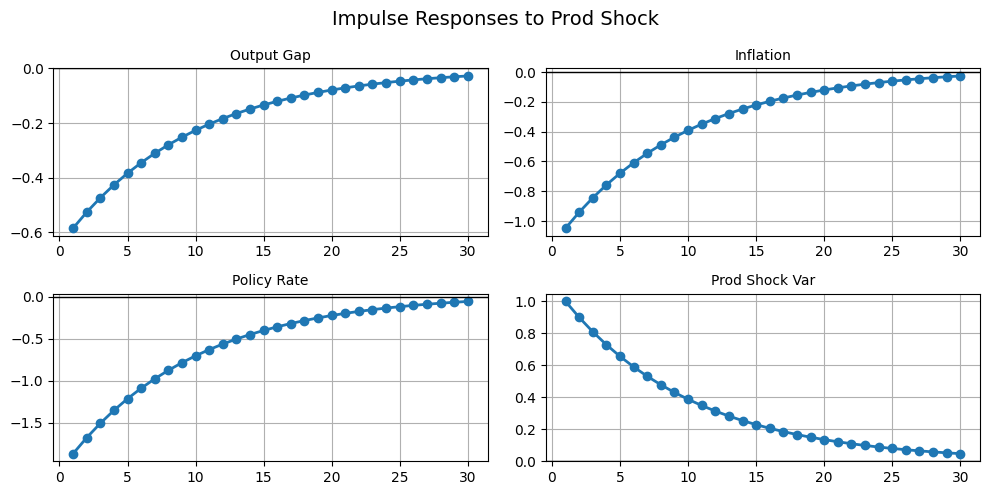

IRFs shape: (6, 30, 3) (variables, horizon, shocks)
Done!


In [27]:
def compute_irfs(G1_sol, C_sol, impact, horizon):
    """
    Compute impulse responses (IRFs) for the linear system:
        y(t) = G1_sol * y(t-1) + C_sol + impact * z(t),
    for each shock in 'impact'.

    Returns: IRFs of shape (n_variables, horizon, n_shocks).
    """
    C_sol = C_sol.flatten()
    n  = G1_sol.shape[0]
    nz = impact.shape[1]

    IRFs = np.zeros((n, horizon, nz))
    for s in range(nz):
        # One-time unit shock at t=0
        ypath = np.zeros((n, horizon))
        zt = np.zeros((nz, horizon))
        zt[s, 0] = 1.0

        for t in range(horizon):
            if t == 0:
                yprev = np.zeros(n)   # assume zero initial condition
            else:
                yprev = ypath[:, t-1]
            
            ycurrent = G1_sol @ yprev + C_sol + impact @ zt[:, t]
            ypath[:, t] = ycurrent

        IRFs[:, :, s] = ypath
    return IRFs


# -------------------------------------------------------------------------
# Computing IRFs and then plotting them in separate graphs
# -------------------------------------------------------------------------

# Main variables: [x_t, π_t, i_t, u_t, m_t, a_t],
# Auxiliary variables: [ z^x_t, z^π_t ]

n = G1_sol.shape[0]
ny = n - nax                 # number of main variables
nz = Impact.shape[1]       # number of shocks

# Make sure these match the actual order of your variables:
varnames   = [
    'Output Gap',        # x_t
    'Inflation',         # π_t
    'Policy Rate',       # i_t
    'Cost Shock Var',    # u_t
    'MP Shock Var',      # m_t
    'Prod Shock Var'     # a_t
]
shocknames = ['Cost Shock','Mon. Policy Shock','Prod Shock']

# Compute IRFs for the main variables only
horizon = 30
IRFs = compute_irfs(G1_sol[:ny, :ny], C_vec[:ny], Impact[:ny, :], horizon=horizon)

# -------------------------------------------------------------------------
# Automatic exclusion based on IRF magnitude
# -------------------------------------------------------------------------
# We'll define a threshold: variables whose IRF never exceeds this value in absolute terms
# over the entire horizon will not appear in the plot.
threshold = 1e-9

timegrid = np.arange(1, horizon+1)

for s in range(nz):
    # Compute peak absolute response for each variable i in [0..ny-1]
    # to shock s over the entire horizon
    peak_responses = [np.max(np.abs(IRFs[i, :, s])) for i in range(ny)]

    # Include only those variables whose peak response is above 'threshold'
    valid_vars = [i for i in range(ny) if peak_responses[i] > threshold]

    if len(valid_vars) == 0:
        print(f"No variable responses exceed threshold for {shocknames[s]}. Skipping plot.")
        continue

    # Plot only the selected variables
    nvars_to_plot = len(valid_vars)
    fig, axs = plt.subplots(
        nrows=(nvars_to_plot + 1)//2,
        ncols=2,
        figsize=(10, 2.5*((nvars_to_plot+1)//2)),
        squeeze=False
    )
    axs = axs.ravel()

    for idx, i_var in enumerate(valid_vars):
        axs[idx].plot(timegrid, IRFs[i_var, :, s], '-o', linewidth=2)
        axs[idx].axhline(0, color='k', linewidth=1)
        axs[idx].grid(True)
        axs[idx].set_title(varnames[i_var], fontsize=10)

    # Hide any remaining unused subplots
    for idx_unused in range(idx+1, len(axs)):
        axs[idx_unused].axis('off')

    fig.suptitle(f"Impulse Responses to {shocknames[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

print("IRFs shape:", IRFs.shape, "(variables, horizon, shocks)")
print("Done!")


#### 6. SIMULATIONS

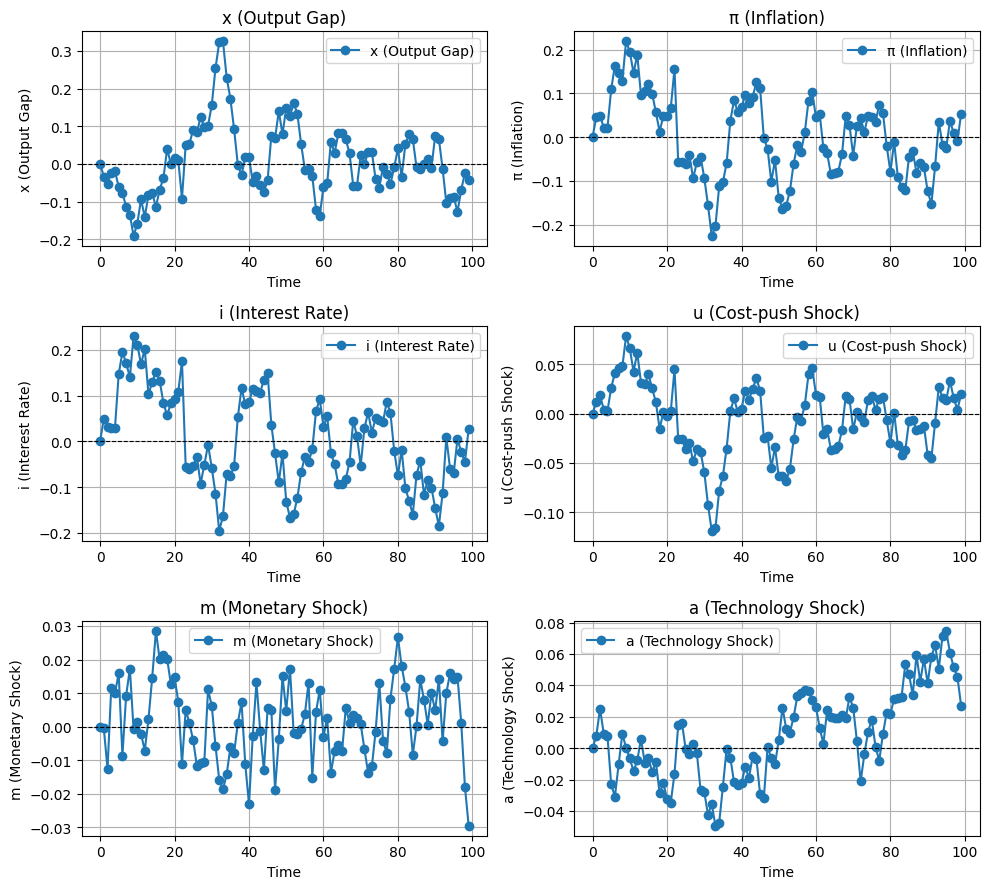

In [31]:

# --------------------------------------------------------------------------
# Simulation Parameters
# --------------------------------------------------------------------------
T = 100  # Number of periods to simulate
n = G1_sol.shape[0]  # Number of endogenous variables
ny = n - nax  # Number of original endogenous variables
num_shocks = Impact.shape[1]  # Number of exogenous shocks

# --------------------------------------------------------------------------
# Set Standard Deviations for Each Shock (set 0 to close a shock)
# --------------------------------------------------------------------------
shock_stds = np.array([
    sigma_u,  # Cost-push shock (u_t)
    sigma_m,  # Monetary shock (m_t)
    sigma_a   # Technology shock (a_t)
])

# --------------------------------------------------------------------------
# Generate Random Shocks
# --------------------------------------------------------------------------
shocks = np.random.normal(0, shock_stds[:, np.newaxis], size=(num_shocks, T))  

# --------------------------------------------------------------------------
# Initialise Variables
# --------------------------------------------------------------------------
y_sim = np.zeros((ny, T))  # Matrix to store simulated endogenous variables

# --------------------------------------------------------------------------
# Simulate Model Dynamics
# --------------------------------------------------------------------------
for t in range(1, T):  
    y_sim[:, t] = G1_sol[:ny,:ny] @ y_sim[:, t-1] + C_vec[:ny].flatten() + Impact[:ny,:] @ shocks[:, t]

# --------------------------------------------------------------------------
# Plot Results
# --------------------------------------------------------------------------
variable_names = ["x (Output Gap)", "π (Inflation)", "i (Interest Rate)", 
                  "u (Cost-push Shock)", "m (Monetary Shock)", "a (Technology Shock)"]

ncols = 2  # 2 columns per row
threshold = 1e-9  # threshold for including variables
ny, T = y_sim.shape

# 1) Identify "valid" variables that surpass the threshold
valid_indices = []
for i in range(ny):
    if np.max(np.abs(y_sim[i, :])) > threshold:
        valid_indices.append(i)

n_valid = len(valid_indices)

# If no variable meets the threshold, just print a message and skip
if n_valid == 0:
    print("No variables exceed threshold; nothing to plot.")
else:
    # 2) Create subplots for the valid variables only
    rows = (n_valid + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=ncols, figsize=(10, 3 * rows), squeeze=False)
    axes = axes.flatten()

    # 3) Plot each valid variable
    for idx, i in enumerate(valid_indices):
        ax = axes[idx]
        ax.plot(y_sim[i, :], label=variable_names[i], marker='o', linestyle='-')
        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax.set_title(variable_names[i])
        ax.set_xlabel("Time")
        ax.set_ylabel(variable_names[i])
        ax.legend()
        ax.grid(True)

    # 4) Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


In [32]:
# Define variable names
variable_names = ["x (Output Gap)", "π (Inflation)", "i (Interest Rate)", 
                  "u (Cost-push Shock)", "m (Monetary Shock)", "a (Technology Shock)"]

# Convert simulation results to DataFrame
simulated_data = pd.DataFrame(y_sim.T, columns=variable_names)

# Select variables for summary statistics (Modify this list as needed)
selected_vars = ["x (Output Gap)", "π (Inflation)", "i (Interest Rate)","u (Cost-push Shock)", "m (Monetary Shock)", "a (Technology Shock)"]  # selection variables for summary statistics

# Compute and print summary statistics for selected variables
summary_stats = simulated_data[selected_vars].describe()

print("\nSummary Statistics:\n", summary_stats)



Summary Statistics:
        x (Output Gap)  π (Inflation)  i (Interest Rate)  u (Cost-push Shock)  \
count      100.000000     100.000000         100.000000           100.000000   
mean         0.008174       0.000922           0.004676            -0.005847   
std          0.096045       0.091940           0.100318             0.037046   
min         -0.191373      -0.225927          -0.196092            -0.119083   
25%         -0.057407      -0.060935          -0.069065            -0.030459   
50%         -0.008033       0.004169          -0.003810             0.000574   
75%          0.065762       0.056906           0.083421             0.017864   
max          0.325971       0.219497           0.230244             0.078791   

       m (Monetary Shock)  a (Technology Shock)  
count          100.000000            100.000000  
mean             0.001681              0.008333  
std              0.011505              0.028214  
min             -0.029666             -0.049609  
25%    

#### 7. VARIANCE DECOMPOSITION

In [33]:
def variance_decomposition(G1_sol, impact, Sigma_z, max_horizon=10):
    """
    Compute the Forecast Error Variance Decomposition (FEVD) for each variable
    and each shock at horizons 1..max_horizon.

    Returns
    -------
    VD : np.ndarray (n, nz, max_horizon)
      fraction of forecast error variance for variable i explained by shock j at horizon h.
      i: variable index, j: shock index, h-1: horizon index in 0..(max_horizon-1).
    """

    # n = number of endogenous variables
    n = G1_sol.shape[0]
    # nz = number of shocks
    nz= impact.shape[1]

    # Prepare an array to store the fraction of variance explained
    #   shape => (n variables, nz shocks, max_horizon horizons)
    VD = np.zeros((n, nz, max_horizon))

    # 1) Precompute powers of G1_sol up to (max_horizon-1).
    #    G_powers[k] = (G1_sol)^k
    G_powers = [np.eye(n)]
    for h in range(1, max_horizon):
        G_powers.append(G_powers[-1] @ G1_sol)

    # 2) For each horizon h in 1..max_horizon:
    for h in range(1, max_horizon+1):
        # total FE covariance for y(t) at horizon h
        FE_var_total = np.zeros((n,n))
        for k in range(h):
            M = G_powers[k] @ impact
            FE_var_total += M @ Sigma_z @ M.T
        var_total = np.diag(FE_var_total)  # shape (n,)

        # partial covariance from each shock j
        for j in range(nz):
            # Build a partial Sigma_z^j that only has the jth diagonal element
            Sigma_z_j = np.zeros_like(Sigma_z)
            Sigma_z_j[j,j] = Sigma_z[j,j]

            FE_var_j = np.zeros((n,n))
            for k in range(h):
                M = G_powers[k] @ impact
                FE_var_j += M @ Sigma_z_j @ M.T
            var_j = np.diag(FE_var_j)

            # fraction => var_j[i]/var_total[i], for each variable i
            fraction = np.zeros(ny)
            nonzero_mask = (var_total > 1e-12)
            fraction[nonzero_mask] = var_j[nonzero_mask]/var_total[nonzero_mask]

            # Store in the 3D array
            VD[:, j, h-1] = fraction

    return VD


# Define the shocks covariance matrix
Sigma_z = np.diag([sigma_u**2, sigma_m**2, sigma_a**2])  # diagonal shocks

# Compute variance decomposition
VD = variance_decomposition(G1_sol[:ny,:ny], Impact[:ny,:], Sigma_z, max_horizon=8)

# varnames and shocknames must match the dimensions "n" and "nz"
varnames   = ["Output Gap", "Inflation", "Interest Rate","Cost Shock", "MP Shock", "Prod Shock"]  # length = 6 => n=6
shocknames = ["Cost Shock", "MP Shock", "Prod Shock"]       # length = 3 => nz=3
max_h      = 6

# Printing table per horizon in a nicer layout:
for h in range(1, max_h+1):
    print(f"\n=== FEVD at Horizon h={h} ===")
    
    # We'll build the table with columns = shock contributions
    # first row => "Variable" + each shock name
    header = ["Variable"] + shocknames
    table_data = [header]

    # For each variable i => one row
    for i in range(ny):
        row_vals = []
        for j in range(nz):
            frac = 100 * VD[i, j, h-1]  # fraction * 100%
            row_vals.append(f"{frac:6.2f}")
        
        # row => [variable name, fraction1, fraction2, fraction3...]
        row = [varnames[i]] + row_vals
        table_data.append(row)

    print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))

print("\nAll done!")


=== FEVD at Horizon h=1 ===
+---------------+------------+----------+------------+
|   Variable    | Cost Shock | MP Shock | Prod Shock |
+---------------+------------+----------+------------+
|  Output Gap   |   94.89    |   2.04   |    3.07    |
|   Inflation   |   90.10    |   0.30   |    9.61    |
| Interest Rate |   75.01    |   0.15   |   24.85    |
|  Cost Shock   |   100.00   |   0.00   |    0.00    |
|   MP Shock    |    0.00    |  100.00  |    0.00    |
|  Prod Shock   |    0.00    |   0.00   |   100.00   |
+---------------+------------+----------+------------+

=== FEVD at Horizon h=2 ===
+---------------+------------+----------+------------+
|   Variable    | Cost Shock | MP Shock | Prod Shock |
+---------------+------------+----------+------------+
|  Output Gap   |   95.05    |   1.55   |    3.40    |
|   Inflation   |   89.27    |   0.22   |   10.51    |
| Interest Rate |   73.15    |   0.11   |   26.74    |
|  Cost Shock   |   100.00   |   0.00   |    0.00    |
|   MP 

#### 8. HISTORICAL DECOMPOSITION

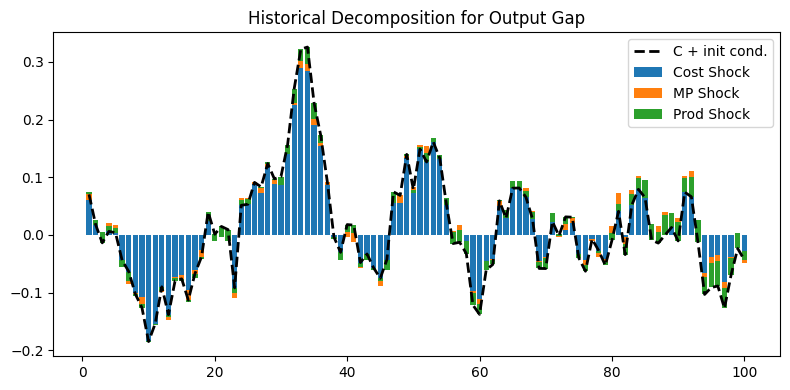

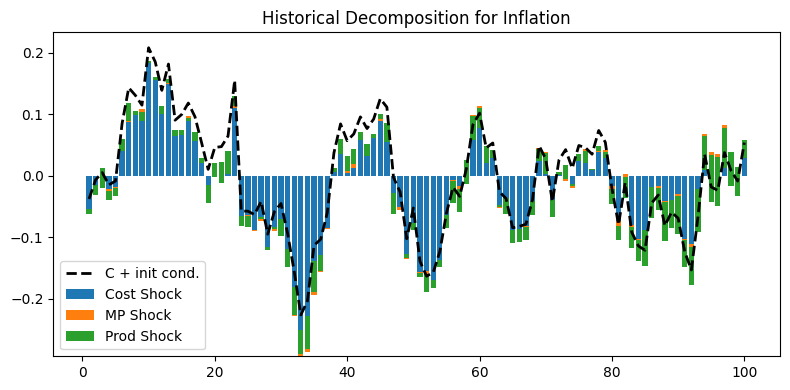

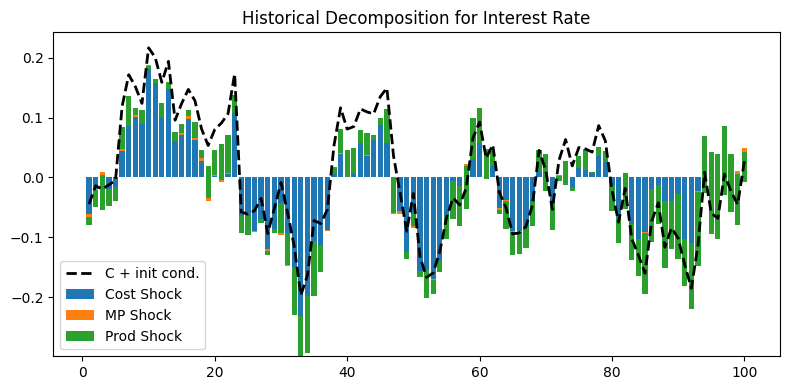

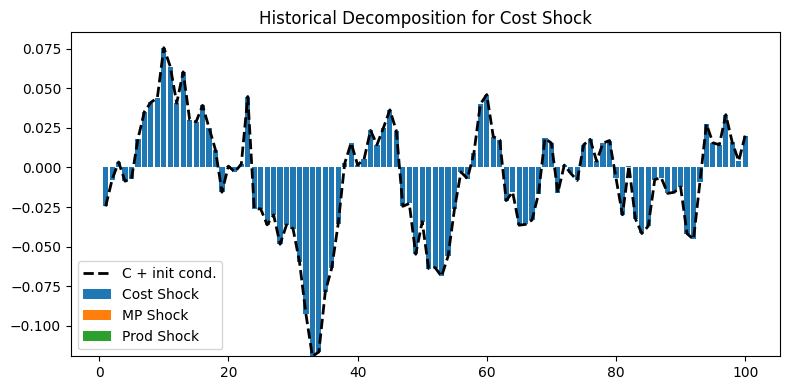

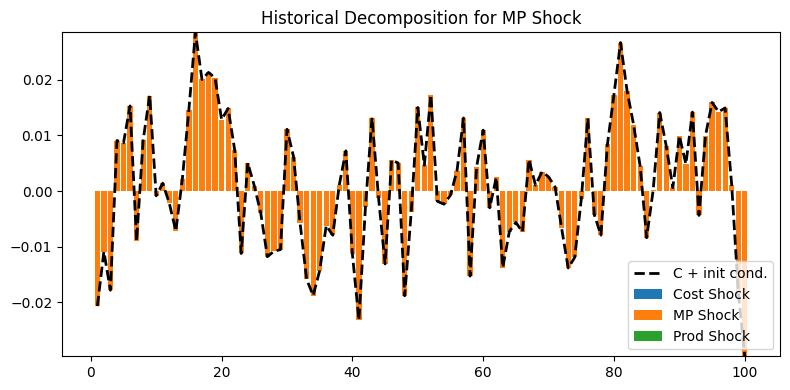

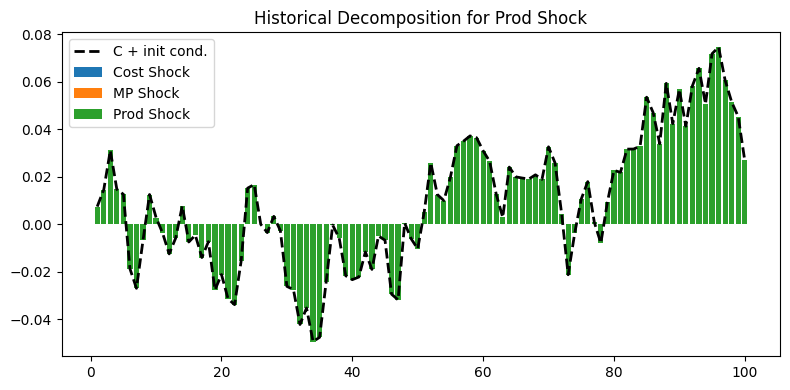

In [35]:
def historical_decomposition(G1_sol, C_sol, Impact, y0, Z_hist):
    """
    Compute historical decomposition for a linear system:
        y(t) = G1_sol @ y(t-1) + C_sol + Impact @ z(t),
    given historical shocks Z_hist of shape (nz, T).

    Parameters
    ----------
    G1_sol : np.ndarray, shape (n, n)
        Transition matrix mapping y(t-1) to y(t).
    C_sol  : np.ndarray, shape (n,)
        Vector of constants.
    Impact : np.ndarray, shape (n, nz)
        Matrix mapping shocks z(t) to y(t).
    y0     : np.ndarray, shape (n,)
        Initial condition y(0).
    Z_hist : np.ndarray, shape (nz, T)
        Historical shocks for T periods (t=1..T).

    Returns
    -------
    HD : np.ndarray, shape (nz, n, T)
        HD[s, i, t] gives the contribution of shock s
        to variable i at time t, for t=1..T.
    deterministic_part : np.ndarray, shape (n, T)
        Contribution from initial conditions and the constant term,
        for each variable and time.
    """

    n = G1_sol.shape[0]
    nz, T = Z_hist.shape

    # Ensure C_sol is flat
    C_sol = C_sol.flatten()

    # This array will store the partial contributions of each shock
    # shape: (nz shocks, n variables, T time)
    HD = np.zeros((nz, n, T))

    # We also separate out the deterministic contribution:
    #  - the path if all shocks were zero, starting from y0
    deterministic_part = np.zeros((n, T))

    # 1) Compute the pure deterministic path (no shocks)
    y_prev = y0.copy()
    for t in range(T):
        y_this = G1_sol @ y_prev + C_sol  # no Impact * shock
        deterministic_part[:, t] = y_this
        y_prev = y_this

    # 2) Compute partial contribution for each shock
    for s in range(nz):
        # Create partial shocks: only shock s is active, the others are zero
        partial_shocks = np.zeros((nz, T))
        partial_shocks[s, :] = Z_hist[s, :].copy()

        # Simulate from the same initial condition y0
        y_prev = y0.copy()
        for t in range(T):
            y_this = G1_sol @ y_prev + C_sol + Impact @ partial_shocks[:, t]
            # The partial contribution is the difference relative to
            # the no-shock path at time t:
            #   y_no_shock(t) + partial_contrib(s) = y_this
            # => partial_contrib(s) = y_this - y_no_shock(t)
            partial_contribution = y_this - deterministic_part[:, t]

            # Store in HD array
            HD[s, :, t] = partial_contribution

            # Update for the next period
            y_prev = y_this

    return HD, deterministic_part

# ---------------------------------------------------------------------------
# Historical decomposition using shocks from simulations exercise
# ---------------------------------------------------------------------------

periods = 100  # Number of periods to simulate
n = G1_sol.shape[0]  # Number of endogenous variables
ny = n - nax  # Number of original endogenous variables
num_shocks = Impact.shape[1]  # Number of exogenous shocks

# Then you can do:
HD, deterministic_part = historical_decomposition(
    G1_sol[:ny,:ny], C_vec[:ny], Impact[:ny,:],
    y0=np.zeros(G1_sol[:ny,:ny].shape[0]),  # or your actual initial state
    Z_hist=shocks
)

# HD[s, i, t] => shock s's contribution to variable i at time t
# deterministic_part[i, t] => constant + initial condition path for variable i

# 3) Recover the total model-implied historical path
# Summing deterministic_part[i,t] + sum over s of HD[s, i, t]
# should match the actual y_sim[i,t] if Z_hist are truly the historical shocks.
T = shocks.shape[1]
n = G1_sol.shape[0]
ny = n - nax

y_reconstructed = np.zeros((ny, T))
for t in range(T):
    y_reconstructed[:, t] = deterministic_part[:, t] + np.sum(HD[:, :, t], axis=0)

# 4) Plot the decompositions for each variable

# varnames and shocknames must match the dimensions n (number of variables) and nz (number of shocks).
varnames   = ["Output Gap", "Inflation", "Interest Rate", "Cost Shock", "MP Shock", "Prod Shock"]  
shocknames = ["Cost Shock", "MP Shock", "Prod Shock"] 

nz = len(shocknames)   # e.g., nz=3

variable_names = [varnames[i] for i in range(ny)]
shock_names    = [shocknames[s] for s in range(nz)]

T = HD.shape[2]  # or however you define T in your code

for i in range(ny):
    fig, ax = plt.subplots(figsize=(8, 4))
    timegrid = range(1, T+1)

    # Plot each shock's contribution over time, stacked
    bottom_stack = np.zeros(T)
    for s in range(nz):
        ax.bar(
            timegrid,
            HD[s, i, :],
            bottom=bottom_stack,
            label=shock_names[s]
        )
        bottom_stack += HD[s, i, :]

    # Add the deterministic part on top of the stacked contributions
    ax.plot(
        timegrid,
        bottom_stack + deterministic_part[i, :],
        'k--',
        label="C + init cond.",
        linewidth=2
    )

    ax.set_title(f"Historical Decomposition for {variable_names[i]}")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()
# The bar chart shows stacked contributions from each shock, with the dashed line
# adding in the deterministic part.
